## 4.1 Unsupervised Learning

In [59]:
import os
import sys
import re
import csv

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from utils import mask_preprocess, dice_coefficient, mask_binarize

# For controlling cell execution
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

%matplotlib inline

In [60]:
## Toggles ##

# To disable truncation for output
np.set_printoptions(threshold=sys.maxsize)

# To disable saving segmented images
save_segmented = False # change to True to download

### Local Paths

In [61]:
## Local Path ##
path = os.path.join('.', 'QC')

## Subfolders ##
train_test_path = os.path.join(path, 'split')

mask_path = os.path.join(path, "mask")
rgb_path = os.path.join(path, "rgb")
image_files = os.listdir(rgb_path)
image_files.sort()

### Extract Train Patient Data

In [62]:
## Obtain All Train Patients ##
train_csv = os.path.join(train_test_path, 'train_subjects.csv')

# Read all patients as list
with open(train_csv, newline='') as f:
    reader = csv.reader(f)
    train_subjects = list(reader)

train_subjects = train_subjects[1:] # remove "Patient id"


## Create Train Patient List ##
train_data = []
for patient in train_subjects:
    for file in image_files:
        if re.match(patient[0], file):
            train_data.append(file)

### Define K Mean

In [63]:
def KMean(image_name, k, download):
    image = cv.cvtColor(cv.imread(os.path.join(rgb_path, image_name)), cv.COLOR_BGR2RGB)
    original_image = image.copy()

    # Convert to 2D rgb array and float type
    image = image.reshape((-1,3))
    image = np.float32(image)
    # plt.imshow(image)

    # Define criteria for termination: 100 iterations or 100 accuracy
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 1.0)

    # Perform K Means
    _, labels, centers = cv.kmeans(image, k, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape((original_image.shape))


    # Switch
    if download == True:
        return segmented_image
    else:
        # Plot the segmented image
        plt.imshow(segmented_image)

### Segment All Train Images
**Caution:** this block will create a new folder

In [64]:
%%skip_if save_segmented == False

# make folder for split
segmented_path = os.path.join(path, 'unsupervised_segmented_train')
os.makedirs(segmented_path, exist_ok=True)

for file in train_data:
    destination = os.path.join(segmented_path, file)
    img = KMean(file, 2, True)
    cv.imwrite(destination, img)

#### Find Optimized k Value
* k = 2
* k = 3
* k = 5
* Compute Dice coefficient

Text(0.5, 0.98, 'Tester Image Segmented with K Mean Clustering Algorithm')

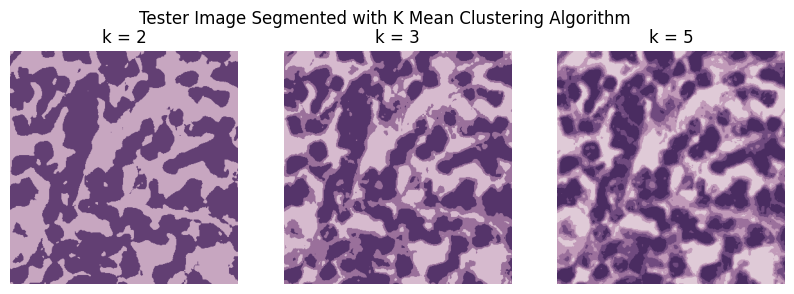

In [65]:
tester = 'TCGA-A1-A0SP-DX1_id-5ea4095addda5f8398977ebc_left-7807_top-53960_bottom-54248_right-8089.png'

k2 = KMean(tester, 2, True)
k3 = KMean(tester, 3, True)
k5 = KMean(tester, 5, True)

plt.figure(figsize=(10, 3.25))
plt.subplot(1, 3, 1)
plt.imshow(k2)
plt.title("k = 2")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(k3)
plt.title("k = 3")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(k5)
plt.title("k = 5")
plt.axis("off")

plt.suptitle('Tester Image Segmented with K Mean Clustering Algorithm')

(-0.5, 354.5, 362.5, -0.5)

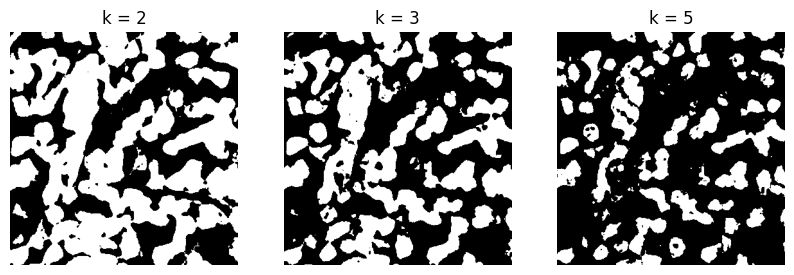

In [66]:
## Binarized Version ##
k2_b = mask_binarize(k2)
k3_b = mask_binarize(k3)
k5_b = mask_binarize(k5)

plt.figure(figsize=(10, 3.25))
plt.subplot(1, 3, 1)
plt.imshow(k2_b, cmap='gray')
plt.title("k = 2")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(k3_b, cmap='gray')
plt.title("k = 3")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(k5_b, cmap='gray')
plt.title("k = 5")
plt.axis("off")

#### Compute Dice Coefficient
$$ dice =  \frac{2(A\cap B)}{A+B} $$

A+B can be obtained by:
$$ A+B = (A\cup B) + (A\cap B) $$

In [67]:
_, mask = mask_preprocess(tester, mask_path)

# K = 2
dice = dice_coefficient(mask, k2_b)
print(f'Dice Score for k=2 is {dice}')

# K = 3
dice = dice_coefficient(mask, k3_b)
print(f'Dice Score for k=3 is {dice}')

# K = 5
dice = dice_coefficient(mask, k5_b)
print(f'Dice Score for k=5 is {dice}')

Dice Score for k=2 is 0.7590776907308237
Dice Score for k=3 is 0.7274282314442957
Dice Score for k=5 is 0.5981193051752771


#### Use Grayscale Image ####

Dice Score for k=2 is 0.7557717962803108
Dice Score for k=3 is 0.7354756486117433
Dice Score for k=5 is 0.6102698268407867


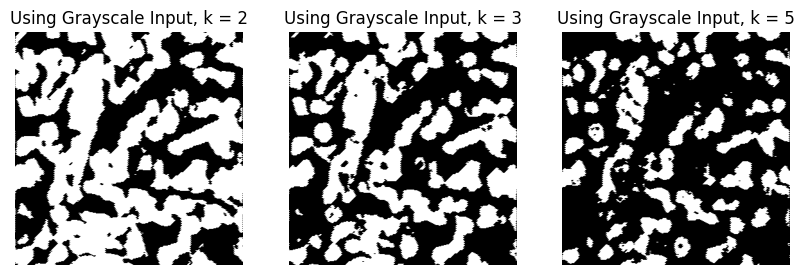

In [68]:
def KMean_gray(image_name, k, download):
    image = cv.cvtColor(cv.imread(os.path.join(rgb_path, image_name)), cv.COLOR_BGR2GRAY)
    original_image = image.copy()

    # Convert to 2D rgb array and float type
    image = image.reshape((-1,3))
    image = np.float32(image)
    # plt.imshow(image)

    # Define criteria for termination: 100 iterations or 100 accuracy
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 1.0)

    # Perform K Means
    _, labels, centers = cv.kmeans(image, k, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape((original_image.shape))


    # Switch
    if download == True:
        return segmented_image
    else:
        # Plot the segmented image
        plt.imshow(segmented_image)

tester = 'TCGA-A1-A0SP-DX1_id-5ea4095addda5f8398977ebc_left-7807_top-53960_bottom-54248_right-8089.png'
k2 = KMean_gray(tester, 2, True)
k3 = KMean_gray(tester, 3, True)
k5 = KMean_gray(tester, 5, True)

## Measure Dice Score ##
k2_b = mask_binarize(k2)
k3_b = mask_binarize(k3)
k5_b = mask_binarize(k5)

## Visualize ##
plt.figure(figsize=(10, 3.25))
plt.subplot(1, 3, 1)
plt.imshow(k2_b, cmap='gray')
plt.title("Using Grayscale Input, k = 2")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(k3_b, cmap='gray')
plt.title("Using Grayscale Input, k = 3")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(k5_b, cmap='gray')
plt.title("Using Grayscale Input, k = 5")
plt.axis("off")

_, mask = mask_preprocess(tester, mask_path)

# K = 2
dice = dice_coefficient(mask, k2_b)
print(f'Dice Score for k=2 is {dice}')

# K = 3
dice = dice_coefficient(mask, k3_b)
print(f'Dice Score for k=3 is {dice}')

# K = 5
dice = dice_coefficient(mask, k5_b)
print(f'Dice Score for k=5 is {dice}')

4.5 Compare to another algorithm: Mean Shift

Dice Score for Mean Shift Segmentation 0.7548391693649902


Text(0.5, 1.0, 'Binary Optimal KMean, k=2')

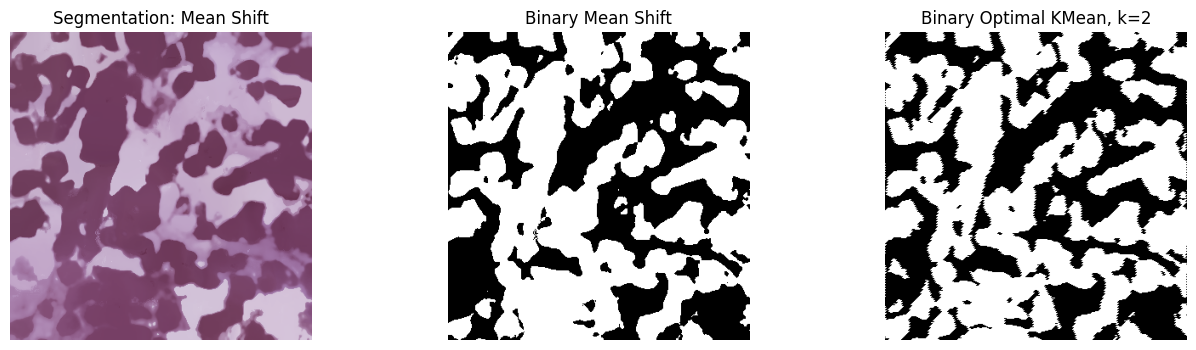

In [69]:
def meanShift(image_name, download):
    img = cv.imread(os.path.join(rgb_path, image_name), cv.COLOR_BGR2RGB)
    output = img.copy()
    # preprocess - gaussian 
    img = cv.GaussianBlur(img, (5, 5), 0.85)
    # define params
    spatialWindow = 40
    colorWindow = 80
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 1)
    
    # meanshift clustering
    cv.pyrMeanShiftFiltering(img, spatialWindow, colorWindow, output, maxLevel=0)
    return output

# mean shift segmentation, binarize   
ms = meanShift(tester, True)
msGray = cv.cvtColor(ms, cv.COLOR_RGB2GRAY)
thresh = 117
_, msB = cv.threshold(msGray, thresh, 255, cv.THRESH_BINARY_INV)

# compare to mask
dice = dice_coefficient(mask, msB)
print(f'Dice Score for Mean Shift Segmentation {dice}')

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(ms)
plt.title('Segmentation: Mean Shift')
plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(msB, cmap='gray')
plt.title('Binary Mean Shift')
plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(k2_b, cmap='gray')
plt.title('Binary Optimal KMean, k=2')